# Introduction

This notebook presents **Sequence-to-Sequence** encoder-decoder architecture based on **LSTM** cells. Neural network is used to learn **English to French** translation task on a small corpus of sequences.

<img src="assets/seq2seq.png"/>
<center>Sequence to sequence architecuter</center>

**Dataset**

* [Udacity NLP Nanodegree](https://eu.udacity.com/course/natural-language-processing-nanodegree--nd892) - I found dataset as part of the course
* [Udacity NLP GitHub](https://github.com/udacity/aind2-nlp-capstone) - dataset link

**Code**

* [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) - code with explanation
* [Official Keras Seq2Seq Example](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py) - code

**Resources**

* [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) (2014) by Ilya Sutskever, Oriol Vinyals, Quoc V. Le
* [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078) (2014) by Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, Yoshua Bengio

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# English to French Dataset

Download dataset from the link in the introduction and point path below to folder with *small_vocab_en* and *small_vocab_fr*

In [3]:
dataset_location = '/home/marcin/Dropbox/Courses/Udacity/NLPND/aind2-nlp-capstone/data/'

*small_vocab_en* contains approx 137860 short sentences in English. *small_vocab_fr* contains corresponding sentences in french.

In [4]:
with open(os.path.join(dataset_location, 'small_vocab_en')) as f:
    # line below: 1) reads lines from file,
    #             2) strips /n char and converts to lowercase,
    #             3) adds special start/end words
    data_en_raw = list(map(lambda x: 'ST '+x.strip().lower()+' EN', f.readlines()))
print('len:', len(data_en_raw))
print('example sentences:')
data_en_raw[4:7]

len: 137860
example sentences:


['ST your least liked fruit is the grape , but my least liked is the apple . EN',
 'ST his favorite fruit is the orange , but my favorite is the grape . EN',
 'ST paris is relaxing during december , but it is usually chilly in july . EN']

In [5]:
with open(os.path.join(dataset_location, 'small_vocab_fr')) as f:
    # line below: 1) reads lines from file,
    #             2) strips /n char and converts to lowercase,
    #             3) adds special start/end words
    data_fr_raw = list(map(lambda x: 'ST '+x.strip().lower()+' EN', f.readlines()))
print('len:', len(data_fr_raw))
print('example sentences:')
data_fr_raw[4:7]

len: 137860
example sentences:


['ST votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . EN',
 "ST son fruit préféré est l'orange , mais mon préféré est le raisin . EN",
 'ST paris est relaxant en décembre , mais il est généralement froid en juillet . EN']

Use Keras tokenizer to convert text sentences to tokens. Each word gets it's own unique integer token. Special words ST/EN also get their tokens.

In [6]:
tok_en = tf.keras.preprocessing.text.Tokenizer(lower=False)
tok_en.fit_on_texts(data_en_raw)
data_en_tok = tok_en.texts_to_sequences(data_en_raw)

In [7]:
print('example tokens for English:')
print('is:', tok_en.word_index['is'], '   ',
      'ST:', tok_en.word_index['ST'], '   ',
      'EN:', tok_en.word_index['EN'], '   ',
      'in:', tok_en.word_index['in'], '   ',
      'it:', tok_en.word_index['it'])
print('example sentences after tokenization:')
data_en_tok[4:7]

example tokens for English:
is: 1     ST: 2     EN: 3     in: 4     it: 5
example sentences after tokenization:


[[2, 31, 14, 18, 15, 1, 7, 84, 8, 32, 14, 18, 1, 7, 85, 3],
 [2, 33, 13, 15, 1, 7, 86, 8, 32, 13, 1, 7, 84, 3],
 [2, 20, 1, 68, 6, 49, 8, 5, 1, 11, 64, 4, 45, 3]]

In [8]:
tok_fr = tf.keras.preprocessing.text.Tokenizer(lower=False)
tok_fr.fit_on_texts(data_fr_raw)
data_fr_tok = tok_fr.texts_to_sequences(data_fr_raw)

In [9]:
print('example tokens for French:')
print('est:', tok_fr.word_index['est'], '   ',
      'ST:', tok_fr.word_index['ST'], '   ',
      'EN:', tok_fr.word_index['EN'], '   ',
      'en:', tok_fr.word_index['en'], '   ',
      'il:', tok_fr.word_index['il'])
print('example sentences after tokenization:')
data_fr_tok[4:7]

example tokens for French:
est: 1     ST: 2     EN: 3     en: 4     il: 5
example sentences after tokenization:


[[2, 42, 15, 16, 18, 1, 12, 84, 7, 41, 15, 16, 1, 9, 85, 3],
 [2, 22, 18, 19, 1, 86, 7, 41, 19, 1, 12, 84, 3],
 [2, 31, 1, 60, 4, 54, 7, 5, 1, 14, 21, 4, 51, 3]]

Calculate maximum sentence lengths

In [10]:
max_len_en = len(max(data_en_tok, key=len))
max_len_fr = len(max(data_fr_tok, key=len))
max_len_both = max(max_len_en, max_len_fr)
print('Max length English sentence (tokens):  ', max_len_en)
print('Max length French sentence (tokens):   ', max_len_fr)
print('Max length in either English or French:', max_len_both, 'tokens (including EN/ST)')

Max length English sentence (tokens):   17
Max length French sentence (tokens):    23
Max length in either English or French: 23 tokens (including EN/ST)


Pad both corpuses to longest sentence in each language

In [11]:
data_en = tf.keras.preprocessing.sequence.pad_sequences(
    data_en_tok, maxlen=max_len_en, padding='post')
data_fr = tf.keras.preprocessing.sequence.pad_sequences(
    data_fr_tok, maxlen=max_len_fr, padding='post')

Print some statistics

In [12]:
n_en_seq = data_en.shape[1]
n_fr_seq = data_fr.shape[1]
n_en_vocab = len(tok_en.word_index)
n_fr_vocab = len(tok_fr.word_index)
max_seq_len = max(n_en_seq, n_fr_seq)
print('Max length English sentence (tokens):   ', n_en_seq)
print('Max length French sentence (tokens):    ', n_fr_seq)
print('Num tokens in English vocabulary:       ', n_en_vocab)
print('Num tokens in English vocabulary:       ', n_fr_vocab)

Max length English sentence (tokens):    17
Max length French sentence (tokens):     23
Num tokens in English vocabulary:        201
Num tokens in English vocabulary:        346


In [13]:
print('English train data')
print('shape:', data_en.shape)
print(data_en[4:7])

English train data
shape: (137860, 17)
[[ 2 31 14 18 15  1  7 84  8 32 14 18  1  7 85  3  0]
 [ 2 33 13 15  1  7 86  8 32 13  1  7 84  3  0  0  0]
 [ 2 20  1 68  6 49  8  5  1 11 64  4 45  3  0  0  0]]


In [14]:
print('French train targets data')
print('shape:', data_fr.shape)
print(data_fr[4:7])

French train targets data
shape: (137860, 23)
[[ 2 42 15 16 18  1 12 84  7 41 15 16  1  9 85  3  0  0  0  0  0  0  0]
 [ 2 22 18 19  1 86  7 41 19  1 12 84  3  0  0  0  0  0  0  0  0  0  0]
 [ 2 31  1 60  4 54  7  5  1 14 21  4 51  3  0  0  0  0  0  0  0  0  0]]


# Sequence to Sequence

We will use technique called 'Teacher Forces' to train decoder. I.e. instead of getting decoder to generate one word at a time and then feed it into the next step in decoder, we will pretend decoder generated correct sequence and just feed in correct inputs. Because we know correct french translation, we don't have to sample one-at-a-time.

To do this we will need two version of French dataset:

* actual target dataset, with ST marker removed
* feed-in target dataset, which we will use as input to decoder, this one contains ST token at first position

In [15]:
data_fr_noST = np.roll(data_fr, shift=-1, axis=-1)  # shift left by one and pad 0 on right
data_fr_noST[:,-1] = 0
print('French train targets data')
print('shape:', data_fr_noST.shape)
print(data_fr_noST[4:7])

French train targets data
shape: (137860, 23)
[[42 15 16 18  1 12 84  7 41 15 16  1  9 85  3  0  0  0  0  0  0  0  0]
 [22 18 19  1 86  7 41 19  1 12 84  3  0  0  0  0  0  0  0  0  0  0  0]
 [31  1 60  4 54  7  5  1 14 21  4 51  3  0  0  0  0  0  0  0  0  0  0]]


Create following parts of graph:
* Encoder
  * inputs: whole English sentence
  * outputs: LSTM hidden states
* Decoder in train mode
  * inputs: LSTM hidden states **and** target French sentence in "teacher forcing" mode (w/o ST token at the begining)
  * outputs: whole French sentence

In [17]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation

# Encoder
E_in = Input(shape=(n_en_seq,), name='Enc_In')                               # (?, 17)
E_emb = Embedding(input_dim=n_en_vocab, output_dim=50, name='Enc_Emb')(E_in) # (?, 17, 50)
_, Eh, Ec = LSTM(units=512, return_state=True, name='Enc_LSTM')(E_emb)       # (?, 512)

# Decoder layer definitions - we will need to reuse these in sampling code later on
decoder_embedding = Embedding(input_dim=n_fr_vocab, output_dim=50, name='Dec_Emb')
decoder_lstm = LSTM(512, return_sequences=True, return_state=True, name='Dec_LSTM')
decoder_dense = Dense(n_fr_vocab, activation='softmax', name='Dec_Out')

# Decoder in train mode
D_in = Input(shape=(n_fr_seq,), name='Dec_Target')                          # (?, 23)
D_emb = decoder_embedding(D_in)                                             # (?, 23, 50)
D_lstm, _, _ = decoder_lstm(D_emb, initial_state=[Eh, Ec])                  # (?, 23, 512)
D_out = decoder_dense(D_lstm)                                               # (?, 23, 346)

Create end-to-end Keras model for training. Contains both encoder and decoder

In [19]:
# full seq-2-seq model
model = tf.keras.Model(inputs=[E_in, D_in], outputs=D_out)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Enc_In (InputLayer)             (None, 17)           0                                            
__________________________________________________________________________________________________
Dec_Target (InputLayer)         (None, 23)           0                                            
__________________________________________________________________________________________________
Enc_Emb (Embedding)             (None, 17, 50)       10050       Enc_In[0][0]                     
__________________________________________________________________________________________________
Dec_Emb (Embedding)             (None, 23, 50)       17300       Dec_Target[0][0]                 
__________________________________________________________________________________________________
Enc_LSTM (

Optional: plot nice diagram and save to file. This requires `graphviz` and `pydot` to be installed.

In [20]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

The result should be as follows

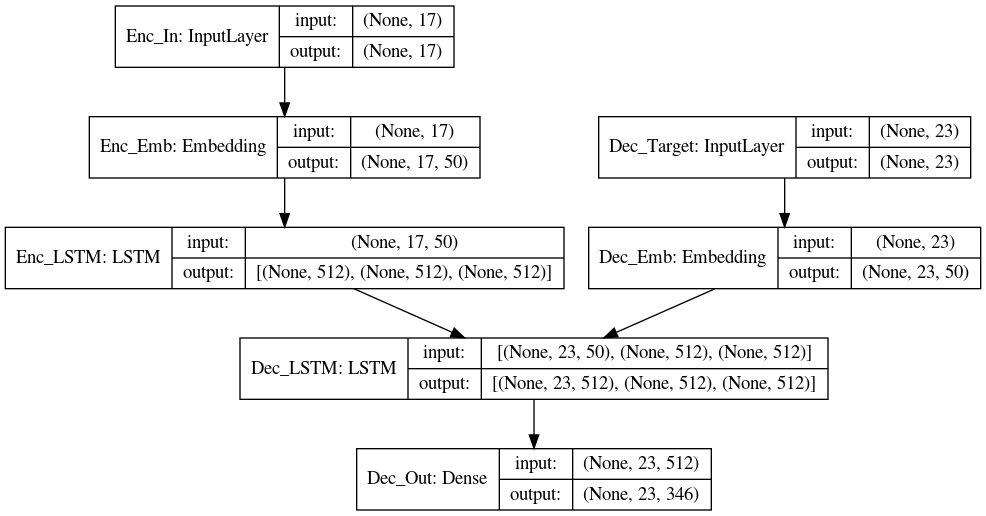

Train model

In [21]:
model.fit(x=[data_en, data_fr], y=np.expand_dims(data_fr_noST, axis=-1),
          batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27572 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
110288/110288 [==============================] - 21s 187us/sample - loss: 2.7985 - sparse_categorical_accuracy: 0.4654 - val_loss: nan - val_sparse_categorical_accuracy: 0.5536
Epoch 2/10
110288/110288 [==============================] - 19s 174us/sample - loss: 1.5292 - sparse_categorical_accuracy: 0.6283 - val_loss: nan - val_sparse_categorical_accuracy: 0.6974
Epoch 3/10
110288/110288 [==============================] - 19s 175us/sample - loss: 0.8839 - sparse_categorical_accuracy: 0.7383 - val_loss: nan - val_sparse_categorical_accuracy: 0.7739
Epoch 4/10
110288/110288 [==============================] - 19s 176us/sample - loss: 0.6470 - sparse_categorical_accuracy: 0.7935 - val_loss: nan - val_sparse_categorical_accuracy: 0.8109
Epoch 5/10
110288/110288 [==============================] - 19s 176us/s

**Model for sampling translations**

Create Keras model for encoder as separate unit

In [22]:
encoder = tf.keras.Model(inputs=E_in, outputs=[Eh, Ec])
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Enc_In (InputLayer)          (None, 17)                0         
_________________________________________________________________
Enc_Emb (Embedding)          (None, 17, 50)            10050     
_________________________________________________________________
Enc_LSTM (LSTM)              [(None, 512), (None, 512) 1153024   
Total params: 1,163,074
Trainable params: 1,163,074
Non-trainable params: 0
_________________________________________________________________


Create decoder in sampling mode, reuse layer definitions form previous section
* Inputs: hidden states **and** single English word-token (not whole French sentence)
* Outputs: single French word-token

In [35]:
Sh_init = Input(shape=(512,))                                          # (?, 512)
Sc_init = Input(shape=(512,))                                          # (?, 512)
S_input = Input(shape=(1,), name='Sam_Input')                          # (?, 1)
S_emb = decoder_embedding(S_input)                                     # (?, 1, 50)
S_lstm, Sh, Sc = decoder_lstm(S_emb, initial_state=[Sh_init, Sc_init]) # (?, 1, 512)
S_output = decoder_dense(S_lstm)                                       # (?, 1, 346) 

Create Keras model for decoder-sampler (one word at a time)

In [36]:
sampler = tf.keras.Model(inputs=[S_input, Sh_init, Sc_init], outputs=[S_output, Sh, Sc])
sampler.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sam_Input (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Dec_Emb (Embedding)             multiple             17300       Sam_Input[0][0]                  
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
Dec_LSTM (

Optional: plot nice diagram

In [37]:
# plot_model(sampler, to_file='sampler.png', show_shapes=True, show_layer_names=True)

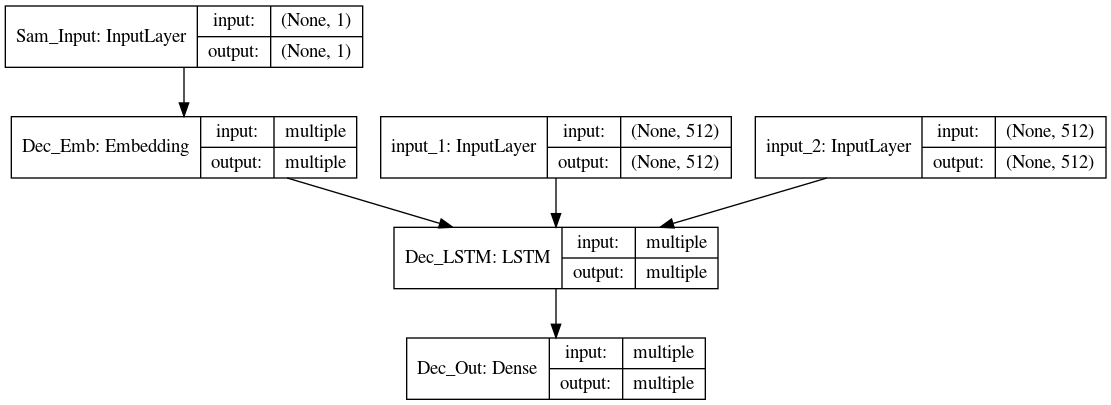

In [39]:
index = 777
english_sentence = data_en_raw[index]
french_sentence = data_fr_raw[index]
print('english:            ', english_sentence)
print('french (original):  ', french_sentence)

english:             ST she liked a rusty black truck . EN
french (original):   ST elle aimait un camion noir rouillé . EN


**Actually Sample**

Run input sentence through encoder

In [40]:
st_h, st_c = encoder.predict(data_en[index:index+1])
assert st_h.shape == (1, 512) and st_c.shape == (1, 512)

Create input variables - thse will be feed into decoder at first decode time step

In [41]:
st_input = tok_fr.word_index['ST']
st_input = np.array([[st_input]])  # batch size = 1, seq len = 1
assert st_input.shape == (1, 1)

Generate output words one-at-a-time and feed them back next time step

In [42]:
prediction_tok = []                     # list of output tokens, generated one at a time
for i in range(n_fr_seq):
    # feed one word (st_input) intot decoder
    probs, st_h, st_c = sampler.predict([st_input, st_h, st_c])
    assert st_h.shape == (1, 512) and st_c.shape == (1, 512)
    
    # pick maximum probability prediction as next word
    # (but keep shape so we can feed in next step)
    st_input = probs.argmax(axis=-1)
    assert st_input.shape == (1, 1)
    
    # pick maximum probability prediction and append to generate list
    # (this does same as line above, but discards shape)
    token = probs.argmax()
    prediction_tok.append(token)
    
    # if decoder generated special end-word, break
    if token == tok_fr.word_index['EN']:
        break    

Print output sentence tokens

In [43]:
prediction_tok

[29, 145, 146, 112, 184, 171, 3]

Helper to convert tokenized sequence back to words

In [44]:
def sequence_to_french(seq):
    words = [tok_fr.index_word[x] for x in seq if x in tok_fr.index_word]
    return ' '.join(words)

Print input english sentence, target French and generated French sentences

In [45]:
print('english:            ', english_sentence)
print('french (original):  ', french_sentence)
predicted_sentence = sequence_to_french(prediction_tok)
print('french (predicted):    ', predicted_sentence)

english:             ST she liked a rusty black truck . EN
french (original):   ST elle aimait un camion noir rouillé . EN
french (predicted):     elle aimait un camion vert rouillé EN
